In [2]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from dask.distributed import Client, progress, wait
from IPython.display import display, HTML
from sklearn.metrics import roc_auc_score
import project_path
from src.util.generate_connected_graph import generate_connected_graph
from src.util.generate_lr_data import generate_low_rank_data
from src.util.generate_anomaly import generate_spatio_temporal_anomaly
from src.algos.lr_stss import lr_stss

In [3]:
client = Client(threads_per_worker=1, n_workers=125)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 125
Total threads: 125,Total memory: 80.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35688,Workers: 125
Dashboard: http://127.0.0.1:8787/status,Total threads: 125
Started: Just now,Total memory: 80.00 GiB
Comm: tcp://127.0.0.1:40424,Total threads: 1
Dashboard: http://127.0.0.1:38964/status,Memory: 655.36 MiB
Nanny: tcp://127.0.0.1:36049,


In [4]:
## Control Variables
gt = 'grid'
graph_param = (8,5)
dtn = 4
amp =1
window = 'boxcar'
distribution = 'bernoulli'
local_distribution = 'constant'
dims = (40,24,7,4)
ranks = (8,8,5,4)
NoG = 1
NoT = 4
NoA = 100
time_m = 2
local_m = 1
lda_2 = 100
psi = 20
maxit = 300
maxit2 = 40
## Independent variables
### Hyperparameters
radius = np.array([0,1,2,3])
lda_1 = np.logspace(1,-3,5)
lda_l = np.logspace(1,-3,5)
lda_t = np.logspace(1,-3,5)

metadata = {'graph_type': gt,
            'graph_param': graph_param,
            'number_of_anomalies': NoA,
            'anomaly_duration': dtn,
            'anomaly_radius': radius,
            'anomaly_amplitude': amp,
            'window': window,
            'distribution': distribution,
            'local_distribution': local_distribution,
            'number_of_graphs': NoG,
            'number_of_trials': NoT,
            'ranks':ranks,
            'dims':dims,
            'time_mode': time_m,
            'local_mode': local_m,
            'lda_2':lda_2,
            'lda_1':lda_1,
            'lda_l':lda_l,
            'lda_t':lda_t,
            'psi': psi,
            'maxit':maxit,
            'maxit2':maxit2,
            }

# Define experiment function
def run_exp(X, Y, an_m, inputs):
    G = inputs['G']
    A = nx.adjacency_matrix(G)
    Deg = np.diag(np.asarray(np.sum(A,axis=1)).ravel())
    Dsq = np.linalg.inv(np.sqrt(Deg))
    An = Dsq@A@Dsq
    Y = inputs['Y']
    Y = np.ma.masked_array(Y, mask=np.zeros(dims,dtype=bool))
    X = inputs['X']
    an_m = inputs['an_m']
    psi = inputs['psi']
    res = lr_stss(Y, An, time_m,local_m, verbose=0, max_it2=40, max_it=300,
        lda2=inputs['lda_2'], lda1=inputs['lda_1'], lda_t=inputs['lda_t'],
        lda_loc=inputs['lda_l'], psis=[psi,psi,psi,psi])
    
    result = {'graph_type': gt,
              'auc': roc_auc_score(an_m.ravel(),np.abs(res['S']).ravel()),
              'rec_err': np.linalg.norm(res['X']-X)/np.linalg.norm(X),
              'anomaly_cardinality': an_m.sum(),
              'number_of_anomalies': NoA,
              'anomaly_duration': dtn,
              'anomaly_radius': inputs['radius'],
              'graph_seed': inputs['graph_seed'],
              'anomaly_seed': inputs['anomaly_seed'],
              'anomaly_amplitude': amp,
              'lda_1': inputs['lda_1'],
              'lda_2': inputs['lda_2'],
              'lda_l': inputs['lda_l'],
              'lda_t': inputs['lda_t'],
              'psi_1': inputs['psi'], 'psi_2': inputs['psi'],
              'psi_3': inputs['psi'], 'psi_4': inputs['psi'],
              'maxit': maxit, 'maxit2': maxit2,
              'it': res['it']}
    return result

In [5]:
try:
    del futures
except:
    pass
futures = []
seed = 35684748
input = {}
for i in range(NoG):
    G,sd = generate_connected_graph(graph_param, gt, radius=graph_param, seed=seed)
    input['G'] = G
    input['graph_type'] = gt
    input['graph_seed'] = sd
    seed = sd
    for j in range(NoT):
        # Generate low rank normal data
        X = generate_low_rank_data(dims, ranks, seed)
        X = 1*X/np.std(X)
        input['X'] = X
        # Generate anomaly
        for k in range(len(radius)):
            input['radius'] = radius[k]
            an, an_m = generate_spatio_temporal_anomaly(dims, G, NoA, duration=dtn,
                                                        radius=radius[k], seed=seed,
                time_m=time_m, local_m=local_m, window_type='boxcar', amplitude=amp,
                distribution=distribution, local_dist='constant')
            input['anomaly_seed'] = seed
            input['an_m'] = an_m
            Y = X+an
            # Y = np.ma.masked_array(Y, mask=np.zeros(dims,dtype=bool))
            input['Y'] = Y
            seed +=1
            for k1 in range(len(lda_1)):
                for k2 in range(len(lda_l)):
                    for k3 in range(len(lda_t)):
                        input['lda_1'] = lda_1[k1]
                        input['lda_l'] = lda_l[k2]
                        input['lda_t'] = lda_t[k3]
                        input['lda_2'] = lda_2
                        input['psi'] = psi
                        futures.append(client.submit(run_exp, X, Y, an_m, input))

Graph is connected.


In [7]:
from dask.distributed import as_completed

fname = 'lr_stss_exp3_hpcc.hdf5'
key = 'grid'
cwd = os.getcwd()
fname = os.path.join(cwd, 'results', fname)

for future in as_completed(futures):
    df = pd.DataFrame(future.result(), index=[i])
    with pd.HDFStore(fname) as storedata:
        storedata.append(key, df)
    del future
    
with pd.HDFStore(fname) as storedata:
    storedata.get_storer(key).attrs.metadata=metadata

2023-06-26 10:34:23,243 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/tornado/websocket.py", line 942, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/tornado/web.py", line 3208, in wrapper
    return method(self, *args, **kwargs)
  File "/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


In [8]:
fname = 'lr_stss_exp3_hpcc.hdf5'
key = 'grid'
cwd = os.getcwd()
fname = os.path.join(cwd, 'results', fname)
with pd.HDFStore(fname) as storedata:
    df = storedata[key]
df.head()

,graph_type,auc,rec_err,anomaly_cardinality,number_of_anomalies,anomaly_duration,anomaly_radius,graph_seed,anomaly_seed,anomaly_amplitude,...,lda_2,lda_l,lda_t,psi_1,psi_2,psi_3,psi_4,maxit,maxit2,it
0,grid,0.575273,0.109177,382,100,4,0,35684748,35684748,1,...,100,10.0,10.000,20,20,20,20,300,40,300
0,grid,0.581091,0.109175,382,100,4,0,35684748,35684748,1,...,100,10.0,1.000,20,20,20,20,300,40,300
0,grid,0.610311,0.109170,382,100,4,0,35684748,35684748,1,...,100,10.0,0.100,20,20,20,20,300,40,300
0,grid,0.623351,0.109167,382,100,4,0,35684748,35684748,1,...,100,10.0,0.010,20,20,20,20,300,40,300
0,grid,0.493403,0.109183,382,100,4,0,35684748,35684748,1,...,100,10.0,0.001,20,20,20,20,300,40,300


In [43]:
import seaborn as sns
dfm = df.groupby(['anomaly_radius','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm2 = dfm.groupby(['anomaly_radius'])['auc'].max()
display(HTML(dfm.to_html()))
# sns.pairplot(dfm)

In [39]:
df.columns
columns = df.columns[1:4].union(df.columns[6:7]).union(df.columns[10:11]).union(df.columns[12:14])
# sns.pairplot(df[columns])
df[columns].corr()

,anomaly_cardinality,anomaly_radius,auc,lda_1,lda_l,lda_t,rec_err
anomaly_cardinality,1.000000e+00,9.939364e-01,-0.045175,2.331594e-17,1.376121e-16,2.128481e-16,0.176418
anomaly_radius,9.939364e-01,1.000000e+00,-0.041829,-3.522787e-17,9.795688e-17,1.876787e-16,0.178880
auc,-4.517504e-02,-4.182914e-02,1.000000,-3.186580e-02,2.101256e-01,-1.786278e-01,-0.524636
lda_1,2.331594e-17,-3.522787e-17,-0.031866,1.000000e+00,-1.067757e-17,-4.186653e-17,-0.345483
lda_l,1.376121e-16,9.795688e-17,0.210126,-1.067757e-17,1.000000e+00,-1.245231e-17,-0.417025
lda_t,2.128481e-16,1.876787e-16,-0.178628,-4.186653e-17,-1.245231e-17,1.000000e+00,-0.376254
rec_err,1.764179e-01,1.788798e-01,-0.524636,-3.454828e-01,-4.170253e-01,-3.762535e-01,1.000000


anomaly_radius
0    0.999987
1    0.997724
2    0.995491
3    0.989923
Name: auc, dtype: float64

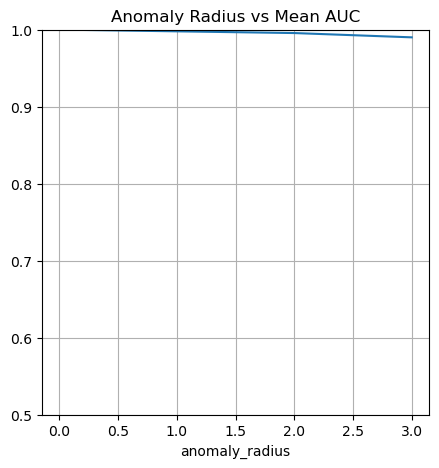

In [44]:
display(dfm2)
fig = plt.figure(figsize=(5,5))
dfm2.plot()
plt.grid()
plt.title("Anomaly Radius vs Mean AUC");
plt.ylim([0.5,1]);

In [ ]:
client.shutdown()